###  Workflow
#### 5.B) Modelling
5.1 Loading the prepared data (see notebook "Data_Preprocesing_Step_2-4")

5.2 Prepare df for the DeepAR Algorithm 

5.3 Creating training and test sets 

5.4 Formatting data as JSON files and uploading to S3

5.5 Instantiating and training a DeepAR estimator

#### 6.A) & 7.A) Evaluation & Deployment
6.1 Prepare Inputdata for Batch Transform Job

6.2 Apply the estimator with Batch Transform on the input data

6.3 Combing Prediction- and Test-Data to an evaluation df 

6.4 Visual Evaluation

6.5 Examination of results resampled to 7 weeks (instead of 49days)

6.6 Scores - calculating the prediction quality scores defined in the Project Proposal

6.7 Final Conclusion

# 5.B) Modelling

### 5.1 Lodaing the prepared data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# load data 
df = pd.read_csv('prepared_data_all.csv')
df.head()

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo_2_active,Open_sunday
0,0,1,5,2015-07-31,5263,1,1,1,1,0,2,0,1270,0,0
1,1,2,5,2015-07-31,6064,1,1,1,1,1,0,0,570,1,0
2,2,3,5,2015-07-31,8314,1,1,1,1,2,0,0,14130,1,0
3,3,4,5,2015-07-31,13995,1,1,1,1,3,2,2,620,0,0
4,4,5,5,2015-07-31,4822,1,1,1,1,4,0,0,29910,0,0


In [5]:
df = df.drop(columns=['Unnamed: 0'])

### 5.2 Prepare df for the DeepAR Algorithm 

In [6]:
# change order of df so latest date comes first
df = df.iloc[::-1]

In [7]:
# for the DeepAr Algorithm, Categorical features must be encoded as a 0-based sequence of positive integers
# thus the stores (which is the category I want to distinguish in this time series) needs to start from zero and not from 1

# reduce all store numbers by one
df ['Store'] =  df.Store.apply(lambda x: (x-1))
df.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo_2_active,Open_sunday
1017208,1114,2,2013-01-01,0,0,0,1,1,1017208,3,2,5350,0,0
1017207,1113,2,2013-01-01,0,0,0,1,1,1017207,0,2,870,0,0
1017206,1112,2,2013-01-01,0,0,0,1,1,1017206,0,2,9260,0,0
1017205,1111,2,2013-01-01,0,0,0,1,1,1017205,2,2,1880,0,0
1017204,1110,2,2013-01-01,0,0,0,1,1,1017204,0,0,1900,0,0


### 5.3 Creating training and test sets 

In [8]:
# filter into train/test before running transformation

# as defined in Proposal: 
# train range 07.01.2013 – 07.06.2015 (94,7% of data)
# test range 08.06.2015-26.07.2015 (5,3% of data) 

# TRAIN
# Filter out all rows with a date past 07.06.2015
df_train = df[df['Date']<'2015-06-08']
# Filter out all rows with a date before 07.01.2013
df_train = df_train[df_train['Date']>='2013-07-01']

# TEST
# !!!!! for this algorithm, the test set contains the complete range of each time series.!!!!!
# Filter out all rows with a date before 08.06.2015
df_test = df[df['Date']>='2013-07-01']
# Filter out all rows with a date past 26.07.2015
df_test = df_test[df_test['Date']<'2015-07-27']

In [9]:
df_train['Date'] = pd.to_datetime(df_train.Date)
df_test['Date'] = pd.to_datetime(df_test.Date)

In [10]:
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

### 5.4 Formatting data as JSON files and uploading to S3

#### Convert to JASON 

In [11]:
# subset a list of Stores to iterate over
store_nr = list(df_train['Store'].unique())

In [12]:
# import json for formatting data and os for saving
import json
import os 

# transforming df

def write_json_dataset(df, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for store in store_nr:
            df_store = df.loc[df['Store'] == store]
            obj = {"start": str(df_store.index[0]), "target": list(df_store.Sales), "cat": [int(store)], "dynamic_feat": [list(df_store.DayOfWeek),list(df_store.Open),list(df_store.Promo),list(df_store.StateHoliday),list(df_store.SchoolHoliday),list(df_store.StoreType),list(df_store.Assortment),list(df_store.CompetitionDistance),list(df_store.Promo_2_active),list(df_store.Open_sunday)]}
            json_line = json.dumps(obj) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [13]:
# save this data to a local directory
data_dir = 'json_rossmann'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [14]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(df_train, train_key)        
write_json_dataset(df_test, test_key)

json_rossmann/train.json saved.
json_rossmann/test.json saved.


#### Store to S3

In [15]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [16]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()

In [17]:
# general prefix
prefix='deepar-rossmann'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [18]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-eu-central-1-395339144106/deepar-rossmann/train/train.json
Test data is stored in: s3://sagemaker-eu-central-1-395339144106/deepar-rossmann/test/test.json


checking a preview of the json the data at s3 through the aws console shows, that all the data is in the right format as indicated in the aws documentation: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html

### 5.5 Instantiating and training a DeepAR estimator

#### 5.5.1. Setup

In [19]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image


In [20]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.p2.xlarge',
                      output_path=s3_output_path
                      )

In [21]:
freq='D'
prediction_length= 49 # number of days in test data set (7 weeks x 7 days)
context_length= 490 # less then number of days in train data set (126 weeks x 7 days); 
# "a model can look further back in the time series than the value specified for context_length"
epochs = 50 # the maximum number of times to pass over the data when training
# Further parameter explenation: https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-recipe-deeparplus.html 

hyperparameters = {
    "epochs": str(epochs),
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "3",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [22]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

#### 5.5.2. Training

In [23]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-04-11 12:43:59 Starting - Starting the training job...
2020-04-11 12:44:00 Starting - Launching requested ML instances...
2020-04-11 12:44:53 Starting - Preparing the instances for training......
2020-04-11 12:45:52 Downloading - Downloading input data
2020-04-11 12:45:52 Training - Downloading the training image......
2020-04-11 12:46:47 Training - Training image download completed. Training in progress.Arguments: train
[04/11/2020 12:46:49 INFO 139744063657792] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'au

[04/11/2020 12:48:21 INFO 139744063657792] Epoch[2] Batch[5] avg_epoch_loss=6.219261
[04/11/2020 12:48:21 INFO 139744063657792] #quality_metric: host=algo-1, epoch=2, batch=5 train loss <loss>=6.2192606926
[04/11/2020 12:48:21 INFO 139744063657792] Epoch[2] Batch [5]#011Speed: 50.03 samples/sec#011loss=6.219261
[04/11/2020 12:48:30 INFO 139744063657792] processed a total of 1241 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25821.024179458618, "sum": 25821.024179458618, "min": 25821.024179458618}}, "EndTime": 1586609310.986223, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1586609285.165125}

[04/11/2020 12:48:30 INFO 139744063657792] #throughput_metric: host=algo-1, train throughput=48.0613910108 records/second
[04/11/2020 12:48:30 INFO 139744063657792] #progress_metric: host=algo-1, completed 6 % of epochs
[04/11/2020 12:48:30 INFO 139744063657792] #quality_metric: host=algo-1, epoch=2, train loss <loss>=6.03981

[04/11/2020 12:50:33 INFO 139744063657792] Epoch[7] Batch[5] avg_epoch_loss=6.168413
[04/11/2020 12:50:33 INFO 139744063657792] #quality_metric: host=algo-1, epoch=7, batch=5 train loss <loss>=6.16841260592
[04/11/2020 12:50:33 INFO 139744063657792] Epoch[7] Batch [5]#011Speed: 50.19 samples/sec#011loss=6.168413
[04/11/2020 12:50:45 INFO 139744063657792] Epoch[7] Batch[10] avg_epoch_loss=6.294470
[04/11/2020 12:50:45 INFO 139744063657792] #quality_metric: host=algo-1, epoch=7, batch=10 train loss <loss>=6.44573936462
[04/11/2020 12:50:45 INFO 139744063657792] Epoch[7] Batch [10]#011Speed: 53.55 samples/sec#011loss=6.445739
[04/11/2020 12:50:45 INFO 139744063657792] processed a total of 1282 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 28204.248189926147, "sum": 28204.248189926147, "min": 28204.248189926147}}, "EndTime": 1586609445.563827, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1586609417.359011}

[04/11/20

[04/11/2020 12:52:59 INFO 139744063657792] processed a total of 1217 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25761.09290122986, "sum": 25761.09290122986, "min": 25761.09290122986}}, "EndTime": 1586609579.204156, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1586609553.442572}

[04/11/2020 12:52:59 INFO 139744063657792] #throughput_metric: host=algo-1, train throughput=47.2415698512 records/second
[04/11/2020 12:52:59 INFO 139744063657792] #progress_metric: host=algo-1, completed 26 % of epochs
[04/11/2020 12:52:59 INFO 139744063657792] #quality_metric: host=algo-1, epoch=12, train loss <loss>=5.66366510391
[04/11/2020 12:52:59 INFO 139744063657792] best epoch loss so far
[04/11/2020 12:52:59 INFO 139744063657792] Saved checkpoint to "/opt/ml/model/state_7db3da7a-1413-4acc-8b5a-375c7f25478c-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 271.36993408203125, "sum": 271.3699340820

[04/11/2020 12:55:26 INFO 139744063657792] Epoch[18] Batch[5] avg_epoch_loss=5.712142
[04/11/2020 12:55:26 INFO 139744063657792] #quality_metric: host=algo-1, epoch=18, batch=5 train loss <loss>=5.71214167277
[04/11/2020 12:55:26 INFO 139744063657792] Epoch[18] Batch [5]#011Speed: 50.28 samples/sec#011loss=5.712142
[04/11/2020 12:55:36 INFO 139744063657792] processed a total of 1276 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25746.910095214844, "sum": 25746.910095214844, "min": 25746.910095214844}}, "EndTime": 1586609736.514495, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1586609710.767004}

[04/11/2020 12:55:36 INFO 139744063657792] #throughput_metric: host=algo-1, train throughput=49.5591182891 records/second
[04/11/2020 12:55:36 INFO 139744063657792] #progress_metric: host=algo-1, completed 38 % of epochs
[04/11/2020 12:55:36 INFO 139744063657792] #quality_metric: host=algo-1, epoch=18, train loss <loss>=5

[04/11/2020 12:57:50 INFO 139744063657792] processed a total of 1273 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25766.48998260498, "sum": 25766.48998260498, "min": 25766.48998260498}}, "EndTime": 1586609870.375598, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1586609844.608571}

[04/11/2020 12:57:50 INFO 139744063657792] #throughput_metric: host=algo-1, train throughput=49.4050283999 records/second
[04/11/2020 12:57:50 INFO 139744063657792] #progress_metric: host=algo-1, completed 48 % of epochs
[04/11/2020 12:57:50 INFO 139744063657792] #quality_metric: host=algo-1, epoch=23, train loss <loss>=5.71867051125
[04/11/2020 12:57:50 INFO 139744063657792] loss did not improve
[04/11/2020 12:57:53 INFO 139744063657792] Epoch[24] Batch[0] avg_epoch_loss=5.782283
[04/11/2020 12:57:53 INFO 139744063657792] #quality_metric: host=algo-1, epoch=24, batch=0 train loss <loss>=5.78228282928
[04/11/2020 12:58:06 INFO 13974406

[04/11/2020 13:00:23 INFO 139744063657792] Epoch[29] Batch[5] avg_epoch_loss=5.672213
[04/11/2020 13:00:23 INFO 139744063657792] #quality_metric: host=algo-1, epoch=29, batch=5 train loss <loss>=5.67221275965
[04/11/2020 13:00:23 INFO 139744063657792] Epoch[29] Batch [5]#011Speed: 50.05 samples/sec#011loss=5.672213
[04/11/2020 13:00:32 INFO 139744063657792] processed a total of 1278 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25840.46983718872, "sum": 25840.46983718872, "min": 25840.46983718872}}, "EndTime": 1586610032.946508, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1586610007.105965}

[04/11/2020 13:00:32 INFO 139744063657792] #throughput_metric: host=algo-1, train throughput=49.4570636818 records/second
[04/11/2020 13:00:32 INFO 139744063657792] #progress_metric: host=algo-1, completed 60 % of epochs
[04/11/2020 13:00:32 INFO 139744063657792] #quality_metric: host=algo-1, epoch=29, train loss <loss>=5.61

[04/11/2020 13:02:46 INFO 139744063657792] processed a total of 1202 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25788.11287879944, "sum": 25788.11287879944, "min": 25788.11287879944}}, "EndTime": 1586610166.859666, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1586610141.070949}

[04/11/2020 13:02:46 INFO 139744063657792] #throughput_metric: host=algo-1, train throughput=46.6103585601 records/second
[04/11/2020 13:02:46 INFO 139744063657792] #progress_metric: host=algo-1, completed 70 % of epochs
[04/11/2020 13:02:46 INFO 139744063657792] #quality_metric: host=algo-1, epoch=34, train loss <loss>=5.81210780144
[04/11/2020 13:02:46 INFO 139744063657792] loss did not improve
[04/11/2020 13:02:50 INFO 139744063657792] Epoch[35] Batch[0] avg_epoch_loss=5.696792
[04/11/2020 13:02:50 INFO 139744063657792] #quality_metric: host=algo-1, epoch=35, batch=0 train loss <loss>=5.6967921257
[04/11/2020 13:03:03 INFO 139744063

[04/11/2020 13:05:16 INFO 139744063657792] Epoch[40] Batch[5] avg_epoch_loss=5.550378
[04/11/2020 13:05:16 INFO 139744063657792] #quality_metric: host=algo-1, epoch=40, batch=5 train loss <loss>=5.55037800471
[04/11/2020 13:05:16 INFO 139744063657792] Epoch[40] Batch [5]#011Speed: 50.24 samples/sec#011loss=5.550378
[04/11/2020 13:05:26 INFO 139744063657792] processed a total of 1254 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25793.297052383423, "sum": 25793.297052383423, "min": 25793.297052383423}}, "EndTime": 1586610326.475589, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1586610300.681735}

[04/11/2020 13:05:26 INFO 139744063657792] #throughput_metric: host=algo-1, train throughput=48.617040814 records/second
[04/11/2020 13:05:26 INFO 139744063657792] #progress_metric: host=algo-1, completed 82 % of epochs
[04/11/2020 13:05:26 INFO 139744063657792] #quality_metric: host=algo-1, epoch=40, train loss <loss>=5.


2020-04-11 13:07:05 Uploading - Uploading generated training model
2020-04-11 13:07:05 Completed - Training job completed
Training seconds: 1284
Billable seconds: 1284
CPU times: user 2.87 s, sys: 128 ms, total: 3 s
Wall time: 23min 23s


#### 5.5.3. create predictor (by deploying estimator) 

In [24]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.p2.xlarge',
    content_type="application/json" # specify that it will accept/produce JSON
)

-------------!CPU times: user 218 ms, sys: 7.48 ms, total: 226 ms
Wall time: 6min 31s


### 6.1 Prepare Inputdata for Batch Transform Job

Calling the preictor directly after transformation of the input data caused a runtime error. Therefore I changed the code to a Batch Transform Prediction.  

#### function to change the df to a json format (similar to the actions for training the model)
each time series (here each store) is one line of json code after transformation
here in addition to the json_object, the configuration is also attached to each time series

In [42]:
def write_predictor_input(df, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for store in store_nr:
            df_store = df.loc[df['Store'] == store]
            l = list(df_store.Sales)
            del l[-49:]
            json_obj = {"start": str(df_store.index[0]), "target": l , "cat": [int(store)], "dynamic_feat": [list(df_store.DayOfWeek),list(df_store.Open),list(df_store.Promo),list(df_store.StateHoliday),list(df_store.SchoolHoliday),list(df_store.StoreType),list(df_store.Assortment),list(df_store.CompetitionDistance),list(df_store.Promo_2_active),list(df_store.Open_sunday)]}
            json_line = json.dumps(json_obj) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

#### Apply function to save data in the right format for the DeppAr Algorithm

In [43]:
# save this data to a local directory
data_dir = 'json_rossmann'

# directories to save train/test data
input_key = os.path.join(data_dir, 'prediction_input.json')

# write train/test JSON files       
write_predictor_input(df_test, input_key)

json_rossmann/prediction_input.json saved.


#### saving the data to S3

In [44]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix='deepar-rossmann'

# *unique* prefix
input_prefix   = '{}/{}'.format(prefix, 'input')

# uploading data to S3, and saving locations
predicton_input_path  = sagemaker_session.upload_data(input_key, bucket=bucket, key_prefix=input_prefix)

# check locations
print('Prediction input data is stored in: '+ predicton_input_path)

Prediction input data is stored in: s3://sagemaker-eu-central-1-395339144106/deepar-rossmann/input/prediction_input.json


### 6.2 Apply the estimator with Batch Transform on the input data

#### Batch Transform job (since the amount of data would cause a timeout otherwise)

You can deploy a model in Amazon SageMaker in one of two ways:

1. Create a persistent HTTPS endpoint where the model provides real-time inference.
2. Run an Amazon SageMaker batch transform job that starts an endpoint, generates inferences on the stored dataset, outputs the inference predictions, and then shuts down the endpoint.

Ressource: https://idk.dev/kinect-energy-uses-amazon-sagemaker-to-forecast-energy-prices-with-machine-learning/

In [49]:
# Batch Transform

import boto3
# Create the SageMaker Boto3 client
boto3_sm = boto3.client('sagemaker')

import time
from time import gmtime, strftime

batch_job_name = 'Batch-Transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
input_location = 's3://sagemaker-eu-central-1-395339144106/deepar-rossmann/input/prediction_input.json'
output_location = 's3://{}/{}/output/{}'.format(bucket, prefix, batch_job_name)
# ModelName is copied from the finished training job at aws console

request = \
{
    "BatchStrategy": "SingleRecord",
    "MaxPayloadInMB": 100,
    "Environment": { 
      "DEEPAR_INFERENCE_CONFIG" : "{ \"num_samples\": 200, \"output_types\": [\"mean\"] }"
    },
    "TransformJobName": batch_job_name,
    "ModelName": 'forecasting-deepar-2020-04-11-12-43-59-000',
    "TransformOutput": {
        "S3OutputPath": output_location,
        "Accept": "application/jsonlines",
        "AssembleWith": "Line"
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": input_location 
            }
        },
        "ContentType": "application/jsonlines",
        "SplitType": "Line",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

boto3_sm.create_transform_job(**request)
print("Created Transform job with name: ", batch_job_name)

# Wait until the job finishes
try:
    boto3_sm.get_waiter('transform_job_completed_or_stopped').wait(TransformJobName=batch_job_name)
finally:
    response = boto3_sm.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    print("Transform job ended with status: " + status) 
    if status == 'Failed':
        message =response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed')

Created Transform job with name:  Batch-Transform-2020-04-11-15-36-15
Transform job ended with status: Completed


### 6.3 Combing Prediction- and Test-Data to an evaluation df 

#### inspect output

In [50]:
import json
import io
from urllib.parse import urlparse

def get_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')

In [51]:
output = get_output_from_s3(output_location, '{}.out'.format('prediction_input.json'))
#https://sagemaker-eu-central-1-395339144106.s3.eu-central-1.amazonaws.com/deepar-rossmann/output/Batch-Transform-2020-04-09-15-19-26/prediction_input.json.out
output_df = pd.read_csv(io.StringIO(output), sep=",", header=None)
output_df.head(8)

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,"{""mean"":[6352.392578125",6575.123047,6610.408691,2996.977295,7204.638184,6760.838867,952.449524,8270.801758,8037.999512,7797.087402,...,7289.915039,5489.554199,140.214890,6243.828125,6028.740723,6163.218262,5079.869141,5801.700684,6102.317383,833.8744506836]}
1,"{""mean"":[18264.33203125",19093.693359,19081.039062,14621.946289,20486.078125,20800.171875,2435.175781,25748.230469,25354.195312,23496.714844,...,21979.554688,18183.724609,-154.034470,19131.591797,18543.007812,17832.832031,17189.560547,17265.917969,19683.068359,1741.5570068359]}
2,"{""mean"":[6179.5581054688",6213.759277,6331.604980,4844.291016,6811.110840,5780.914551,2143.238037,8439.578125,7628.790527,7196.263672,...,6678.464844,4132.436035,1581.128906,6514.938965,6210.221191,5871.979492,6187.371094,5212.675781,5595.889160,2323.7133789062]}
3,"{""mean"":[9192.353515625",9306.931641,9408.528320,6609.193848,9205.817383,8572.919922,608.152466,13090.581055,11572.150391,11314.943359,...,10242.112305,7825.897949,-473.276520,9255.820312,8191.044922,8258.742188,8186.986328,8395.960938,8335.890625,391.9510192871]}
4,"{""mean"":[4686.095703125",5130.481445,5256.989258,3236.602783,5404.422363,3383.168945,592.418701,7169.732910,6461.916016,6119.839355,...,5693.755859,2966.348633,128.893005,4739.219238,4444.552734,4586.955078,4021.224365,4841.950195,3575.426270,492.0267944336]}
5,"{""mean"":[4099.8735351562",4338.166992,4592.481445,4248.053223,4791.046387,4135.703613,319.530548,6327.191406,5888.340820,5219.727051,...,5086.933594,3804.678467,-151.082062,4610.651855,4269.686523,4324.590820,4490.320801,4229.374512,4109.731445,232.5650787354]}
6,"{""mean"":[4847.8198242188",4951.769531,4971.519043,3303.602295,5125.896973,4230.516113,500.208832,6047.744141,5837.962891,5768.151367,...,5107.523926,3457.525879,392.947662,4362.834473,4065.383789,4734.355957,4101.372070,4463.334961,3947.220703,715.4653930664]}
7,"{""mean"":[5291.474609375",5275.431152,5383.338867,4918.258301,6053.262695,3591.156006,571.656067,8721.339844,7576.875488,6803.608887,...,6643.603516,3788.581787,-308.018768,5555.177734,5069.062012,5165.120117,5326.488281,5574.573242,4527.734863,393.7833862305]}


Explanation:

each line represents a store (starting with store nr 1115 like in the input data) and each column holds the sales prediction for one of the 49 days 

#### cleaning & formatting the prediction df

In [55]:
# deleting '{"mean":[' from the beginning of each column 0 and ']}' from the end of each column 48
output_df[0] = output_df[0].str.lstrip('{"mean":[')
output_df[48] = output_df[48].str.rstrip(']}')
output_df.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,6352.392578125,6575.123047,6610.408691,2996.977295,7204.638184,6760.838867,952.449524,8270.801758,8037.999512,7797.087402,...,7289.915039,5489.554199,140.214890,6243.828125,6028.740723,6163.218262,5079.869141,5801.700684,6102.317383,833.8744506836
1,18264.33203125,19093.693359,19081.039062,14621.946289,20486.078125,20800.171875,2435.175781,25748.230469,25354.195312,23496.714844,...,21979.554688,18183.724609,-154.034470,19131.591797,18543.007812,17832.832031,17189.560547,17265.917969,19683.068359,1741.5570068359
2,6179.5581054688,6213.759277,6331.604980,4844.291016,6811.110840,5780.914551,2143.238037,8439.578125,7628.790527,7196.263672,...,6678.464844,4132.436035,1581.128906,6514.938965,6210.221191,5871.979492,6187.371094,5212.675781,5595.889160,2323.7133789062
3,9192.353515625,9306.931641,9408.528320,6609.193848,9205.817383,8572.919922,608.152466,13090.581055,11572.150391,11314.943359,...,10242.112305,7825.897949,-473.276520,9255.820312,8191.044922,8258.742188,8186.986328,8395.960938,8335.890625,391.9510192871
4,4686.095703125,5130.481445,5256.989258,3236.602783,5404.422363,3383.168945,592.418701,7169.732910,6461.916016,6119.839355,...,5693.755859,2966.348633,128.893005,4739.219238,4444.552734,4586.955078,4021.224365,4841.950195,3575.426270,492.0267944336


In [60]:
# change all columns to int for better overview
output_df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]] = output_df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]].astype('int')

# change negative predictions to zero (as negative sales doesn't make sense)
output_df[output_df < 0] = 0
output_df.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,6352,6575,6610,2996,7204,6760,952,8270,8037,7797,...,7289,5489,140,6243,6028,6163,5079,5801,6102,833
1,18264,19093,19081,14621,20486,20800,2435,25748,25354,23496,...,21979,18183,-154,19131,18543,17832,17189,17265,19683,1741
2,6179,6213,6331,4844,6811,5780,2143,8439,7628,7196,...,6678,4132,1581,6514,6210,5871,6187,5212,5595,2323
3,9192,9306,9408,6609,9205,8572,608,13090,11572,11314,...,10242,7825,-473,9255,8191,8258,8186,8395,8335,391
4,4686,5130,5256,3236,5404,3383,592,7169,6461,6119,...,5693,2966,128,4739,4444,4586,4021,4841,3575,492


In [72]:
# stack the columns, so there is only one column with all predictions (49 rows store A, than 49 rows store B,..)
stacked_df = output_df.stack(dropna=False)
stacked_df = stacked_df.reset_index()
stacked_df.head()

,level_0,level_1,0
0,0,0,6352
1,0,1,6575
2,0,2,6610
3,0,3,2996
4,0,4,7204


#### combining the prediction with the test data 

In [71]:
# get prepared evaluation dates nd store numbers in right format from benchmark model noteboook 
deepar_eval_df = pd.read_csv('prepared_evaluation.csv')
deepar_eval_df.head()

,Unnamed: 0,Date,Store,Prediction_Amount,Method,Parameter
0,0,2015-06-08,1115,5778.679619,SimpleExpSmoothing,default
1,1,2015-06-09,1115,5778.679619,SimpleExpSmoothing,default
2,2,2015-06-10,1115,5778.679619,SimpleExpSmoothing,default
3,3,2015-06-11,1115,5778.679619,SimpleExpSmoothing,default
4,4,2015-06-12,1115,5778.679619,SimpleExpSmoothing,default


In [73]:
# use column Date and Store from deepar_eval_df and merge with column '0' from stacked_df
result = pd.concat([deepar_eval_df.Date, deepar_eval_df.Store, stacked_df[0]], axis=1, sort=False)
result.head()

,Date,Store,0
0,2015-06-08,1115,6352
1,2015-06-09,1115,6575
2,2015-06-10,1115,6610
3,2015-06-11,1115,2996
4,2015-06-12,1115,7204


In [75]:
# get prepared actual_sales df from benchmark model noteboook 
actual_sales_df = pd.read_csv('actual_sales_evaluation.csv')
actual_sales_df.head()

,Unnamed: 0,Date,Store,Sales
0,60209,2015-06-08,1115,5920
1,60208,2015-06-08,1114,20368
2,60207,2015-06-08,1113,5939
3,60206,2015-06-08,1112,7878
4,60205,2015-06-08,1111,4567


In [83]:
# merge with actual sales from actual_sales_df, since the format is different it will be merged based on Date and Store
evaluation_df = pd.merge(result, actual_sales_df,  how='left', left_on=['Date','Store'], right_on = ['Date','Store'])
# delete 'Unnamed: 0', rename 0
evaluation_df = evaluation_df.drop(columns=['Unnamed: 0'])
evaluation_df = evaluation_df.rename(columns={0: "Prediction"})
evaluation_df.head()

,Date,Store,Prediction,Sales
0,2015-06-08,1115,6352,5920
1,2015-06-09,1115,6575,5119
2,2015-06-10,1115,6610,4676
3,2015-06-11,1115,2996,5216
4,2015-06-12,1115,7204,5315


### 6.4 Visual Evaluation

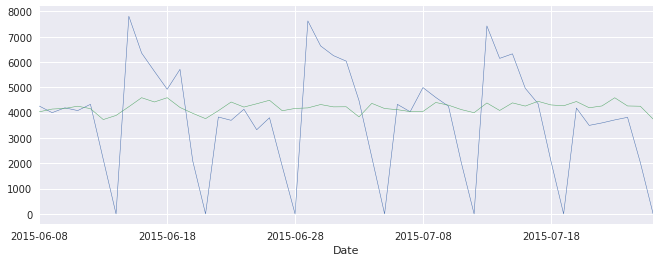

In [85]:
# plot result for one store as example visualization
test_vis_5 = evaluation_df[evaluation_df['Store']==5]

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

test_vis_5 = test_vis_5.set_index('Date')
test_vis_5['Sales'].plot(linewidth=0.5);
test_vis_5['Prediction'].plot(linewidth=0.5);

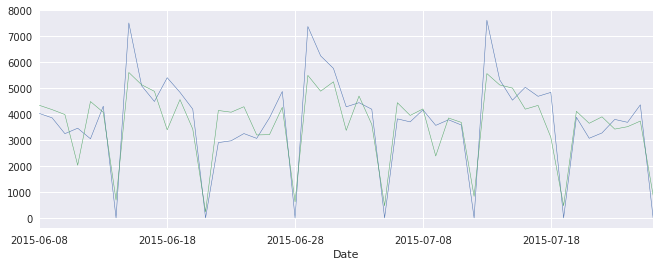

In [86]:
# plot result for one store as example visualization
test_vis_50 = evaluation_df[evaluation_df['Store']==50]

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

test_vis_50 = test_vis_50.set_index('Date')
test_vis_50['Sales'].plot(linewidth=0.5);
test_vis_50['Prediction'].plot(linewidth=0.5);

#### Visual Evaluation Conclusion

The two randomly chosen examples seem very interesting to me. The first one (for store no.5) is similar to my benchmark model with an almost linear prediction that seems to do a decent job in the mean but doesn't really predict the fluctuation of the stores demand. The second visualization however seems astonishingly precise to me. The prediction doesn't reach the highest peaks on Mondays but it seemed to have recognised the overall idea of every second week having higher demand and sundays being without sales usually. This second prediction is much better than the benchmark model.  

### 6.5 Examination of results resampled to 7 weeks (instead of 49days)

In [87]:
# compare the sum of sales over the 49 days 
# sum demand per store (= demand for 7 weeks) in order to compare easier

# group prediction per store
evaluation_resampled_pred = evaluation_df.groupby('Store')['Prediction'].sum().reset_index()
evaluation_resampled_pred.columns = ['Store','Prediction']

# group actual demand per store
evaluation_resampled_actu = evaluation_df.groupby('Store')['Sales'].sum().reset_index()
evaluation_resampled_actu.columns = ['Store','Sales']

# combine the 2 df
resampled_df = evaluation_resampled_actu.copy()
resampled_df['Prediction'] = resampled_df.Store.map(evaluation_resampled_pred.set_index('Store')['Prediction'].to_dict())
resampled_df.head()

,Store,Sales,Prediction
0,1,178499,196384
1,2,202435,211824
2,3,285635,311643
3,4,404191,416874
4,5,185834,206192


#### Conclusion resampled data

It seems that the sum of demand over the 7 weeks prediction period is very close to the sum of actual demand over 7 weeks. Considering this use case I guess it is more comon for a manager to order on a two-weekly or weekly basis than on a daily basis. So this result might actually be kind of good for this use case. Let's have a look at evaluation scores. 

### 6.6 Scores - calculating the prediction quality scores defined in the Project Proposal

#### for the regualr data (per day)

In [91]:
y_true = evaluation_df['Sales'].to_numpy()
y_pred = evaluation_df['Prediction'].to_numpy()

import numpy as np 
rmse = (np.sqrt(np.mean(np.square((y_true - y_pred)))))
print ("The absolute mean error (RMSE) is about {}.".format(round(rmse)))

The absolute mean error (RMSE) is about 1544.0.


In [89]:
df_no_zero = evaluation_df[evaluation_df['Sales'] > 0]
y_true = df_no_zero['Sales'].to_numpy()
y_pred = df_no_zero['Prediction'].to_numpy()
rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100
print ("The relative (percentage) mean error (RMSPE) is about {}%.".format(round(rmspe)))

The relative (percentage) mean error (RMSPE) is about 23.0%.


#### for the resampled data

In [93]:
y_true = resampled_df['Sales'].to_numpy()
y_pred = resampled_df['Prediction'].to_numpy()
 
#add epsilon as a very small constant to the denominator so that even in the case that y_true equals 0, the denominator as a whole won’t
EPSILON =  1e-10 
rmse = (np.sqrt(np.mean(np.square((y_true - y_pred)))))
rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON))))) * 100
print ("The absolute mean error (RMSE) is about {}.".format(round(rmse)))
print ("The relative (percentage) mean error (RMSPE) is about {}%.".format(round(rmspe)))

The absolute mean error (RMSE) is about 25012.0.
The relative (percentage) mean error (RMSPE) is about 9.0%.


### 6.7 Final Conclusion

Comparing the results with the benchmark model, it is clear, that on a daily basis forecast, the DeepAr prediction is much better. The RMSE is only about half the size of the benchmark model! The difference in the RMSPE is only 5% between the models though. This is because for calculationg this score we devide by the actual value and in order to due so without error I had to filter all the days with actual sales zero out of the RMSPE calculation. Especially at these days the DeepAR was very good at recognizing the reaccurring pattern of zero sales on regular sundays while the benchmark model predicted the same for each day. 

What is a surprise to me, is, that on prediction lenghth of one week (combined 7 day predictions to one wekk prediction) the simple benchmark model seems to be more accurate. 

Thus my finaly brief recommendation at this point would be to use the DeepAR for exact predictions per day and the benchmark if weekly forecasts are sufficient. 